In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from os import listdir, mkdir, remove
from os.path import isfile, join
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('russian')
nltk.download('punkt')
from nltk import word_tokenize

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
morph=MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 8.2MB 22.6MB/s 


Данные находятся по ссылке: https://drive.google.com/drive/folders/15O7a2MoL3-oZXHm8NTm4xhl4fsEjvQC5?usp=sharing

# Функции

Данная программа предназначена для обработки данных, содержащих тексты и метаинформацию новостных публикаций некоторых региональных и центральных СМИ (полный список приведен в readme). </br> На первом этапе работы был сздан набор функций, предназначенныx для:
* очищения строки слова от специальных символов (clean_word_symbols)
* очищения строки слов отсимволов (clean_symbols)
* лемматизации строки текста с помощью морфологического парсера PyMorphe2, удаления из нее стоп-слов на основе списка из библиотеки NLTK, очищения строки от слов короче двух символов (lemmatize)
* только удаления стоп слов (clean_sw)
* функция, объединяющая все вышеописанные, совершающая полную предобработку текста: возвращает соединенный пробелами чистый список лемм текста (transfor_text).

In [ ]:
#удалить символы с границ слова
def clean_word_symbols(text, symbols=None):
  text.replace('\xa0', ' ')
  if symbols:
    return text.strip(''.join(symbols))
  else:
    while text and not text[0].isalpha():
      text = text.lstrip(text[0])
    while text and not text[-1].isalpha():
      text = text.rstrip(text[-1])
    return text

#удалить символы из строки
def clean_symbols(text, symbols=None):
  words = [clean_word_symbols(t, symbols=symbols) for t in text.split()]
  return ' '.join(words)

#лемматизировать текст и, если нужно, удалить стоп-слова: возвращает соединенный пробелом список лемм
def lemmatize(text, stopwords=False):
  if stopwords:
    words = [word for word in word_tokenize(text.lower()) if word.isalpha() and not word in sw]
    lems = [morph.parse(word)[0].normal_form for word in words if not word in sw]
    return ' '.join([l for l in lems if len(l)>2])
  else:
    words = [word for word in word_tokenize(text.lower(), language='russian') if word.isalpha()]
    lems = [morph.parse(word)[0].normal_form for word in words if not word in sw]
    return ' '.join([l for l in lems if len(l)>2])

#специальная ункция для удаления стоп-слов
def clean_sw(text):
  return ' '.join([word for word in text.split() if not word in sw])

#предобработать текст: возвращает соединенный пробелом список лемм
def transfrom_text(text, symbols=None, stopwords=True):
  no_sym = clean_symbols(text, symbols=symbols)
  lighter = clean_sw(no_sym)
  lem = lemmatize(lighter, stopwords=stopwords)
  return lem

Большая часть текстов коллеции задана в едином формате:</br>
=====</br>
ссылка на публикацию</br>
название источника </br>
дата публикации</br>
автор</br>
название статьи</br>
текст статьи</br>
Первая из следющих функций принимает на вход название файла и возвращает список, в котором каждым элементом является другой список, в котором в свою очередь хранится вся считанная информация, описанная выше. </br>
Вторая функция с использованием первой по названию файла возвращает Датафрейм со всеми публикациями и  информацией о них.</br>
Третья функция прирнимает на вход такой датафрейм, конкатенирует заголовок и текст (необходимые для исследования лингвистические данные) и производит их предобработку.

In [ ]:
#прочитать документ с корпусом публикаций правильно заданного источника
def read_corpus(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
      for l in f:
          if l=="=====\n":
              j = 0
              res.append(record)
              record = []
          elif j < 6:
              j += 1
              record.append(l.strip("\n"))
          else:
              record[-1] += l.strip("\n")
  res.append(record)
  return res

#Создать из файла датафрем с информацией о нем
def corpus_df(filename):
  c = read_corpus(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["link", "source", "date", "author", "title", "text"])
  return df

#предобработать текстовую информацию и вернуть релевантные для работы данные: текст и дату публикации
def transform_corpus(df, symbols=None, stopwords=True, date=True):
  if date:
    df_new = pd.DataFrame(columns=['date', 'text'])
    df_new['date'] = df['date'].copy()
  else:
    df_new = pd.DataFrame(columns=['date', 'text'])
  if 'title' and 'text' in df.columns:
    df_new['title_text'] = df.apply(lambda x: ' '.join([x.title, x.text]) if x.title and x.text else '', axis=1)
    df_new['text'] = df_new['title_text'].apply(lambda x: transfrom_text(x, symbols=symbols, stopwords=stopwords))
  else:
    df_new['text'] = df['text'].apply(lambda x: transfrom_text(x, symbols=symbols, stopwords=stopwords))
  return df_new[['text', 'date']]

Для того чтобы произвести разведочный анализ данных, необходимо собрать информацию о имеющихся документах: 
* к какой коллекции они принадлежат: центральной или региональной
* название источника, откуда была взята публикация
* количество документов из этого источника, которым мы распологаем
* количество уникальных лемм в документах корпуса
* средняя длина документа в токенах
* дата первой и последней имеющейсяв нашем распоряжении публикации в источнике

In [ ]:
info_df = pd.DataFrame(columns=['collection', 'source', 'n_docs', 'n_unique_tokens', 'avg_doc_len', 'date_first', 'date_last'])

def get_n_docs(df):
  return df.shape[0]

def get_n_unique_tokens(df):
  frequency = defaultdict(int)
  for text in df['text'].to_list():
    for token in str(text).split():
      frequency[token] += 1
  return len(frequency)

def get_mean_doc_len(df):
  lens = [len(str(text).split()) for text in df['text'].to_list()]
  return np.mean(lens)

def get_dates(df):
  dates = df['date'].to_list()
  return dates[0], dates[-2]

def get_info(df):
  info = []
  info.append(get_n_docs(df))
  info.append(get_n_unique_tokens(df))
  info.append(get_mean_doc_len(df))
  info.extend(get_dates(df))
  return info

# Обработка региональных корпусов в правильном формате

Следующие функции производят сбор и сохранение обработанных корпусов в новой директории:

In [ ]:
def one_corpus(filename, path, newdir, info_df=info_df):
  full_path = join(path, filename)

  df1 = corpus_df(full_path)
  df1 = transform_corpus(df1)
  new_name = filename[:-4] + '.csv'
  new_path = join(path, newdir, new_name)
  df1.to_csv(new_path, index=False)


def all_corpora(path, newdir):
  new_path = join(path, newdir)
  os.mkdir(new_path)
  files = [f for f in listdir(path) if isfile(join(path, f))]
  for f in files:
    one_corpus(f, path, newdir)

СОздаем новую директорию внути той, где хранятся данные регионального корпуса, и созраняем туда таблицы с обработанными данными.

In [1]:
path = "/preprocessing_data/regional_corpora"
newdir = "lem_corpora"

all_corpora(path, newdir)

# Обработка корпусов нетрадиционного формата

Следующие функции предназначены для обработки корпусов, заданных в нетрадиционном формате, и полностью повторяют этапы обработки для остального корпуса.

In [ ]:
old_path = join(path, 'articles_Вечерний_Волгоград.txt')
new_path = join(path, 'articles_Вечерний_Волгоград1.txt')
with open(old_path) as f:
  text = f.read()
text = text.replace('######', '=====')
with open(new_path, 'w') as f:
  f.write(text)

vv = corpus_df(new_path)
vv = transform_corpus(vv)

csv_path = join(path, newdir, 'articles_Вечерний_Волгоград.csv')
vv.to_csv(csv_path, index=False)
remove(new_path)

In [ ]:
old_path = join(path, 'articles_Светлый_Путь.txt')
new_path = join(path, 'articles_Светлый_Путь1.txt')
with open(old_path) as f:
  text = f.read()
text = text.replace('======', '=====')
with open(new_path, 'w') as f:
  f.write(text)

put = corpus_df(new_path)
put = transform_corpus(put)

csv_path = join(path, newdir, 'articles_Светлый_Путь.csv')
put.to_csv(csv_path, index=False)
remove(new_path)

In [ ]:
full_path = join(path, 'articles_Сафоновская_Правда.txt')

def read_corpus1(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
    for l in f:
      if l.lstrip()=="=====\n":
        j = 0
        res.append(record)
        record = []
      elif j == 0 or j == 3 or j == 2:
        j += 1
        record.append(l.strip("\n"))
      elif j == 1:
        j += 1
        record.extend(l.strip("\n").split("\т"))
      else:
        record[-1] += l.strip("\n")
  res.append(record)
  return res

def corpus_df1(filename):
  c = read_corpus1(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["link", "source", "date", "title", "text"])
  return df

sp = corpus_df1(full_path)
sp = transform_corpus(sp)

csv_path = join(path, newdir, 'articles_Сафоновская_Правда.csv')
sp.to_csv(csv_path, index=False)

In [1]:
full_path = join(path, 'articles_Курские_Городские_Известия.txt')

def read_corpus2(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
      for l in f:
          if l=="=====\n":
              j = 0
              res.append(record)
              record = []
          elif j < 5:
              j += 1
              record.append(l.strip("\n")
          else:
              record[-1] += l.strip("\n")
  res.append(record)
  return res

def corpus_df2(filename):
  c = read_corpus2(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["link", "source", "date", "title", "text"])
  return df

kgi = corpus_df2(full_path)
kgi = transform_corpus(kgi)

csv_path = join(path, newdir, 'articles_Курские_Городские_Известия.csv')
kgi.to_csv(csv_path, index=False)

# Полный корпус региональных СМИ

В следующей части программы производится объединение полученных на предыдущих этапах корпусов источников в один большой корпус коллекции, а также сбор информации об источниках в датафрейм info_df. 

In [ ]:
path = "preprocessing_data/regional_corpora"
newdir = "lem_corpora"
path = join(path, newdir)
files = [f for f in listdir(path) if isfile(join(path, f))]

reg_df = pd.DataFrame(columns=['text', 'date', 'source'])
for f in files:
  full_path = join(path, f)
  df = pd.read_csv(full_path).dropna(subset=['text'])
  df['text'] == df['text'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>2]))
  source = f[9:-4]
  info = get_info(df)
  info_record = pd.DataFrame({'collection':'regional', 
                              'source': source,
                              'n_docs': info[0],
                              'n_unique_tokens': info[1],
                              'avg_doc_len':info[2],
                              'date_first': info[3],
                              'date_last': info[4]}, 
                             index=[0])
  info_df = info_df.append(info_record, ignore_index=True)
  df['source'] = source
  reg_df = reg_df.append(df, ignore_index=True)

In [ ]:
reg_df.shape

(275082, 3)

In [ ]:
reg_df.to_csv(join(path, "01_articles_региональная_коллекция.csv"), encoding='utf-8-sig')

# Обработка центральных СМИ

Корпуса центральных СМИ не имеют общей структуры, так что к их обработке пришлось подойти индивидуально, однаок этапы обработки повторяют те6 что были применены к региональному корпусу.

In [ ]:
path = "preprocessing_data/central_corpora"
newdir = "lem_corpora1"
new_path = join(path, newdir)
#os.mkdir(new_path)

## n+1

In [ ]:
def read_nplus1(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
      for l in f:
          if l=="----------\n":
              j = 0
              res.append(record)
              record = []
          elif j == 0 or j == 3:
            j += 1
          elif j == 1 or j == 2 or j == 4:
              j += 1
              record.append(l.strip("\n").replace('\xa0', ' '))
          else:
              record[-1] += l.strip("\n").replace('\xa0', ' ')
  res.append(record)
  return res

def nplus1_df(filename):
  c = read_nplus1(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["title", "date", "text"])
  return df

In [ ]:
nplus1 = 'nplus1-2018.txt'
filename = join(path, nplus1)
df = nplus1_df(filename)
df = transform_corpus(df)

csv_path = join(path, newdir, nplus1.replace('txt', 'csv'))
df.to_csv(csv_path, index=False)

## gazeta.ru

In [ ]:
def read_gazeta(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
      for l in f:
          if l=="----------\n":
              j = 0
              res.append(record)
              record = []
          elif j < 3:
              j += 1
              record.append(l.strip("\n").replace('\xa0', ' '))
          else:
              record[-1] += l.strip("\n").replace('\xa0', ' ')
  res.append(record)
  return res

def gazeta_df(filename):
  c = read_gazeta(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["title", "date", "text"])
  return df

In [ ]:
gazeta = 'gazeta_ru-2018.txt'
filename = join(path, gazeta)
df = gazeta_df(filename)
df = transform_corpus(df)

csv_path = join(path, newdir, gazeta.replace('txt', 'csv'))
df.to_csv(csv_path, index=False)

## rbc

In [ ]:
def read_rbc(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
    for l in f:
      if l=="----------\n":
          j = 0
          res.append(record)
          record = []
      elif l.startswith("        Теги:"):
        j = -1
      elif j == 0:
        j += 1
      elif j == 1 or j == 2:
          j += 1
          record.append(l.strip("\n").replace('\xa0', ' '))
      elif j == 3:
          record[-1] += l.strip("\n").replace('\xa0', ' ')
  res.append(record)
  return res

def rbc_df(filename):
  c = read_rbc(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["title", "text"])
  return df

In [ ]:
rbc2 = 'rbc_2018_2.txt'
filename = join(path, rbc2)
df = rbc_df(filename)
df = transform_corpus(df, date=False)

csv_path = join(path, newdir, rbc2.replace('txt', 'csv'))
df.to_csv(csv_path, index=False)

# Полный корпус центральных СМИ

Создание таблицы с объединенным корпусом коллекци центральных СМИ и сбор инфомации о корпусах.

In [ ]:
path = "preprocessing_data/central_corpora"
newdir = "lem_corpora"
path = join(path, newdir)
files = [f for f in listdir(path) if isfile(join(path, f))]

centre_df = pd.DataFrame(columns=['text', 'date', 'source'])
for f in files:
  full_path = join(path, f)
  df = pd.read_csv(full_path).dropna(subset=['text'])
  df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
  source = f[:-4]
  info = get_info(df)
  info_record = pd.DataFrame({'collection':'central', 
                              'source': source,
                              'n_docs': info[0],
                              'n_unique_tokens': info[1],
                              'avg_doc_len':info[2],
                              'date_first': info[3],
                              'date_last': info[4]}, 
                             index=[0])
  info_df = info_df.append(info_record, ignore_index=True)
  df['source'] = source
  centre_df = centre_df.append(df, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
centre_df.shape

(201003, 3)

In [ ]:
centre_df.to_csv(join(path, "01_articles_центральная_коллекция.csv"), encoding='utf-8-sig')

# Информация о коллекциях

Проведем небольшое исследование имеющихся у нас данных.

In [ ]:
info_df

,collection,source,n_docs,n_unique_tokens,avg_doc_len,date_first,date_last
0,regional,рассвет-якшур-бодья,2375,23986,213.685895,30.09.2020,24.02.2015
1,regional,Советская Адыгея,318,7360,168.182390,2020-10-07,2020-07-27
2,regional,Газета_Юга,9022,55739,206.276768,10 января 2019,26 декабря 2002
3,regional,Молодой_Коммунар,551,7240,99.431942,3 года назад,5 лет назад
4,regional,Волгоградская_Правда,79928,159873,176.878428,13.10.2020,13.10.2020
5,regional,Вперед,4396,34208,235.225205,Дата: 05.10.2020,Дата: 25.08.2017
6,regional,Авангард,3380,35271,272.137278,30.11.2010,01.09.2015
7,regional,Красное_Прикамье,4432,38848,186.245036,11-10-2018,6-01-2010
8,regional,Сельская правда,14506,52114,226.485592,22.05.2018,13.07.2010
9,regional,Вечерний_Челябинск,19986,56353,131.509407,16.10.2020,дата отсутствует


## Редактирование формата дат

Даты в каждом корупсе были заданы разным способом, произведем извлечение года публикации и обновим информационный датафрейм.

In [ ]:
def date_format(text):
  t = ''.join([c if c.isdigit() else ' ' for c in str(text)])
  t = [c for c in t.split()]
  d = [len(c) for c in t]
  if 4 in d:
    return t[d.index(4)]
  else:
    return None

In [ ]:
info_df['date_first'] = info_df['date_first'].apply(lambda x: date_format(x) if x else None)
info_df['date_last'] = info_df['date_last'].apply(lambda x: date_format(x) if x else None)

In [ ]:
info_df

,collection,source,n_docs,n_unique_tokens,avg_doc_len,date_first,date_last
0,regional,рассвет-якшур-бодья,2375,23986,213.685895,2020,2015
1,regional,Советская Адыгея,318,7360,168.182390,2020,2020
2,regional,Газета_Юга,9022,55739,206.276768,2019,2002
3,regional,Молодой_Коммунар,551,7240,99.431942,None,None
4,regional,Волгоградская_Правда,79928,159873,176.878428,2020,2020
5,regional,Вперед,4396,34208,235.225205,2020,2017
6,regional,Авангард,3380,35271,272.137278,2010,2015
7,regional,Красное_Прикамье,4432,38848,186.245036,2018,2010
8,regional,Сельская правда,14506,52114,226.485592,2018,2010
9,regional,Вечерний_Челябинск,19986,56353,131.509407,2020,None


In [ ]:
filename = join('data_info.csv')
info_df.to_csv(filename, index=False)

## Исследование коллекции

In [ ]:
print('Количество региональных источников: {}'.format(info_df[info_df['collection']=='regional'].shape[0]))
print('Список региональных источников: {}'.format(',\n'.join(list(info_df[info_df['collection']=='regional']['source'].unique()))))

Количество региональных источников: 24
Список региональных источников: рассвет-якшур-бодья,
Советская Адыгея,
Газета_Юга,
Молодой_Коммунар,
Волгоградская_Правда,
Вперед,
Авангард,
Красное_Прикамье,
Сельская правда,
Вечерний_Челябинск,
Кабардино-Балкарская_Правда,
Риск,
Вестник_района,
Благодарненские_вести,
Вечерний_Ставрополь,
Чебоксарские_новости,
Починковский_район,
Гжатский_вестник,
Курские_Городские_Известия,
Молодой_Коммунар_Тула,
Вечерний_Волгоград,
Светлый_Путь,
Сафоновская_Правда,
Можгинские_Вести


In [ ]:
print('Количество центральных источников: {}'.format(info_df[info_df['collection']=='central'].shape[0]))
print('Список центральных источников: {}'.format(',\n'.join(list(info_df[info_df['collection']=='central']['source'].unique()))))

Количество центральных источников: 3
Список центральных источников: nplus1-2018,
gazeta_ru-2018,
rbc_2018_2


In [ ]:
reg_dates = list(map(int, info_df[info_df['collection']=='regional']['date_first'].dropna().unique()))
reg_dates.extend(list(map(int,info_df[info_df['collection']=='regional']['date_last'].dropna().unique())))
print('Региональные новости с {} по {} год'.format(min(reg_dates), max(reg_dates)))
c_dates = list(map(int, info_df[info_df['collection']=='central']['date_first'].dropna().unique()))
c_dates.extend(list(map(int,info_df[info_df['collection']=='central']['date_last'].dropna().unique())))
print('Центральные новости с {} по {} год'.format(min(c_dates), max(c_dates)))

Региональные новости с 2002 по 2020 год
Центральные новости с 2016 по 2018 год


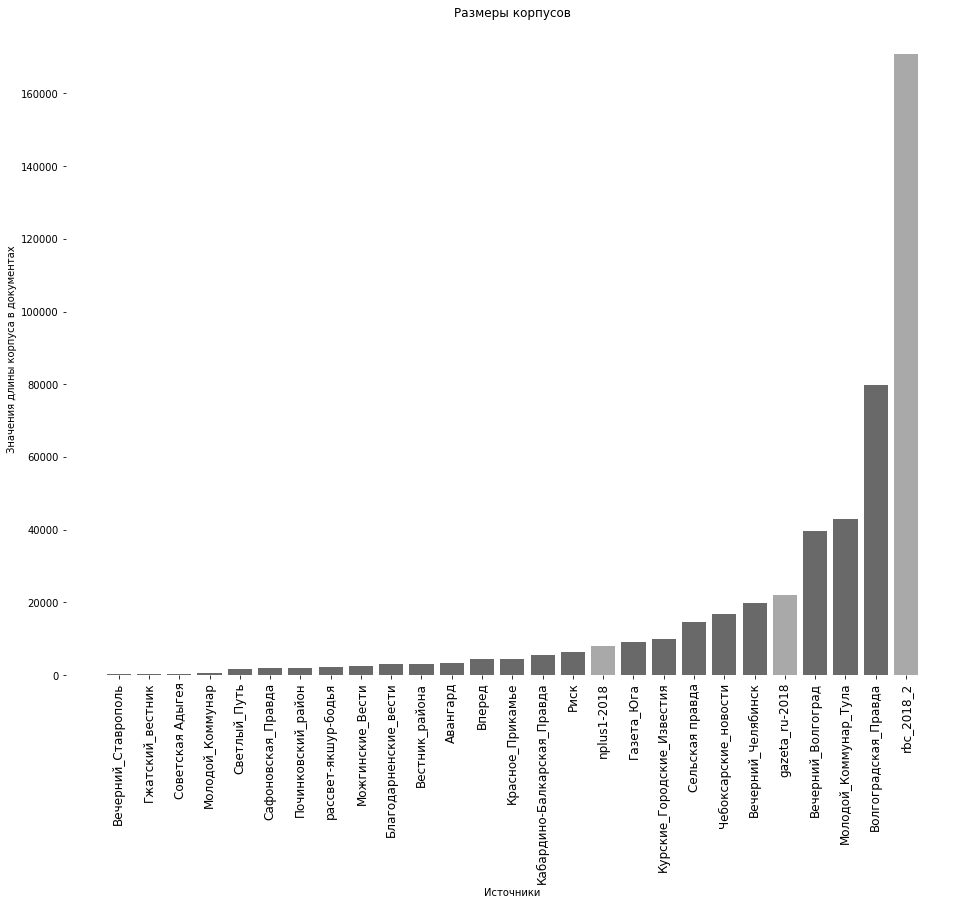

In [ ]:
plt.figure(figsize=(16,12))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

color = ['dimgrey' if c=='regional' else 'darkgrey' for c in info_df.sort_values(by=['n_docs'])['collection']]
plt.bar(info_df.sort_values(by=['n_docs'])['source'], info_df.sort_values(by=['n_docs'])['n_docs'], color=color)

plt.title('Размеры корпусов', fontsize=12)
plt.xticks(info_df.sort_values(by=['n_docs'])['source'], fontsize=12, rotation=90) 
plt.xlabel('Источники', fontsize=10)
plt.ylabel('Значения длины корпуса в документах', fontsize=10)
plt.savefig('N_docs.png')
plt.show()

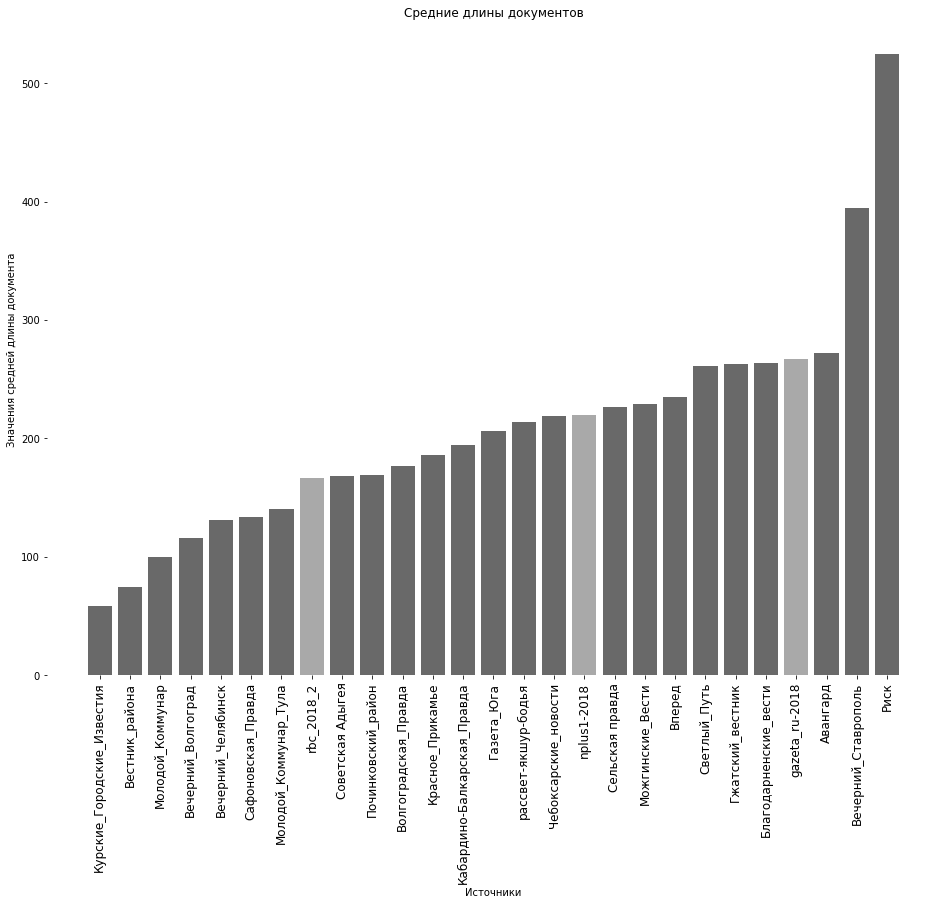

In [ ]:
plt.figure(figsize=(16,12))

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

color = ['dimgrey' if c=='regional' else 'darkgrey' for c in info_df.sort_values(by=['avg_doc_len'])['collection']]
plt.bar(info_df.sort_values(by=['avg_doc_len'])['source'], info_df.sort_values(by=['avg_doc_len'])['avg_doc_len'], color=color)

plt.title('Средние длины документов', fontsize=12)
plt.xticks(info_df.sort_values(by=['avg_doc_len'])['source'], fontsize=12, rotation=90) 
plt.xlabel('Источники', fontsize=10)
plt.ylabel('Значения средней длины документа', fontsize=10)
plt.savefig('Avg_doc_len.png')
plt.show()

In [ ]:
reg_n_docs = np.sum(np.array(info_df[info_df['collection']=='regional']['n_docs']))
c_n_docs = np.sum(np.array(info_df[info_df['collection']=='central']['n_docs']))

reg_n_tokens = np.dot(np.array(info_df[info_df['collection']=='regional']['avg_doc_len']),
                         np.array(info_df[info_df['collection']=='regional']['n_docs']))
c_n_tokens = np.dot(np.array(info_df[info_df['collection']=='central']['avg_doc_len']),
                         np.array(info_df[info_df['collection']=='central']['n_docs']))

reg_avg_doc_len = reg_n_tokens / reg_n_docs
c_avg_doc_len = c_n_tokens / c_n_docs


print('Количество документов в региональной коллекции: {}'.format(reg_n_docs))
print('Размер региональной коллекции в токенах: {}'.format(int(np.round(reg_n_tokens,0))))
print('Средняя длина документов в региональной коллекции: {}'.format(np.round(reg_avg_doc_len, 3)), end='\n\n')

print('Количество документов в центральной коллекции: {}'.format(c_n_docs))
print('Размер центральной коллекции в токенах: {}'.format(int(np.round(c_n_tokens,0))))
print('Средняя длина документов в центральной коллекции: {}'.format(np.round(c_avg_doc_len, 3)))

Количество документов в региональной коллекции: 275082
Размер региональной коллекции в токенах: 47450256
Средняя длина документов в региональной коллекции: 172.495

Количество документов в центральной коллекции: 201003
Размер центральной коллекции в токенах: 36200841
Средняя длина документов в центральной коллекции: 180.101
